In [ ]:
# !pip install imblearn
# !pip install seaborn
# !pip install joblib

In [1]:
import pandas as pd
import numpy as np
import warnings

import sklearn.feature_extraction

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import joblib

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier



In [2]:
warnings.filterwarnings('ignore')

%matplotlib inline


In [3]:
global plotAu, grid_vc, plotCm
plotAuc = False
grid_vc = False
plotCm  = False
feat_import = False

In [4]:
##### FUNCTIONS #####

## função para plotar matriz de confusão
def plot_cm(cm, labels):
    
    # calcula porcentagens 
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)
    
    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()) )

    # Show confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
## função para plotar AUC Curve 
def plot_auc_curve(clf, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _  = sklearn.metrics.roc_curve(y_test,  y_pred_proba)
    auc          = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)

    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

## função para executar modelos de ML
def run_ml(modelos, X_train,X_test,y_train,y_test):
    
    for m in modelos:
        print("\n==>",m.__class__.__name__)
        clf = Pipeline([('clf', m )])

        clf       = clf.fit(np.asarray(X_train), y_train)
        predicted = clf.predict(np.asarray(X_test))
        print("  Accuracy  = %f \n" % accuracy_score(y_test, predicted))
        
        labels = list(np.unique(y_train)) #[0,1]
        cm     = confusion_matrix(y_test, predicted,labels=labels)
        
        if plotCm:
            plot_cm(cm,labels)

        if hasattr(clf, 'predict_proba') and plotAuc:
            plot_auc_curve(clf, X_test, y_test)

    print("================================================================================================")

    ##  CHECKING FEATURES IMPORTANCES 
    if feat_import:
        for m in modelos:
            print("\n==>",m.__class__.__name__)
            cols = X_train.columns
            m.fit(np.asarray(X_train),y_train)

            if hasattr(m, 'feature_importances_'):
                x_labels = X_train.columns[:]
                prob     = list()        
                cols     = list()        
                features = m.feature_importances_
                for i,l in zip(x_labels,features):
                    if l*100 > int( np.mean(features)*100 ):
                        cols.append(i)
                print("  Cols: ", cols)

            clf  = m.fit(np.asarray(X_train.loc[:,cols]), y_train)
            predicted = clf.predict(np.asarray(X_test.loc[:,cols]))

            print("  Accuracy  = %f \n" % accuracy_score(y_test, predicted))
            labels = list(np.unique(y_train)) #[0,1]
            cm     = confusion_matrix(y_test, predicted,labels=labels)    

            if plotCm:
                plot_cm(cm,labels)

            if hasattr(clf, 'predict_proba') and plotAuc:
                plot_auc_curve(clf, X_test.loc[:,cols], y_test)



In [5]:
dados = pd.read_csv("winequality.csv", sep = ';')

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null object
quality                 6497 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 659.9+ KB


In [7]:
dados.columns = ['type', 'fixed_acidity', 'volatile_acidity', 'citric_acid','residual_sugar',
                 'chlorides', 'free_sulfur_dioxide','total_sulfur_dioxide', 'density', 'pH',
                 'sulphates', 'alcohol','quality']

In [8]:
dados.isnull().values.any()

False

In [9]:
## identificando registros inconsistentes na coluna alcohol
lista = list()
for i,a in dados.iterrows():
    if len(a["alcohol"]) > 5:
        #print(i,a["alcohol"])
        lista.append(i)

In [10]:
indices  = dados.loc[lista,"quality"].value_counts().index#.plot(kind = 'bar')

In [11]:
dados_clean = dados.iloc[~dados.index.isin(lista),:]
dados_clean.alcohol = pd.to_numeric(dados_clean.alcohol)

In [12]:
## SUBSTITUINDO VALORES INCORRETOS NA COLUNA alcohol
for i in indices:
    media = dados_clean.loc[dados_clean.quality == i,'alcohol'].mean()
    dados.loc[(dados.quality == i) & (dados.index.isin(lista)),'alcohol'] = media
    
## CONVERTENDO COLUNA PARA TIPO NUMERICO
dados.alcohol = pd.to_numeric(dados.alcohol)

In [13]:
## CONVERTENDO COLUNA PARA TIPO NUMERICO
label_type    = preprocessing.LabelEncoder()
dados["type"] = label_type.fit_transform(dados.type)

In [14]:
## DIVIDINDO OS DADOS SEM O ATRIBUTO TARGET(QUALITY) 
x = dados.iloc[:,:-1]
x.head()


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


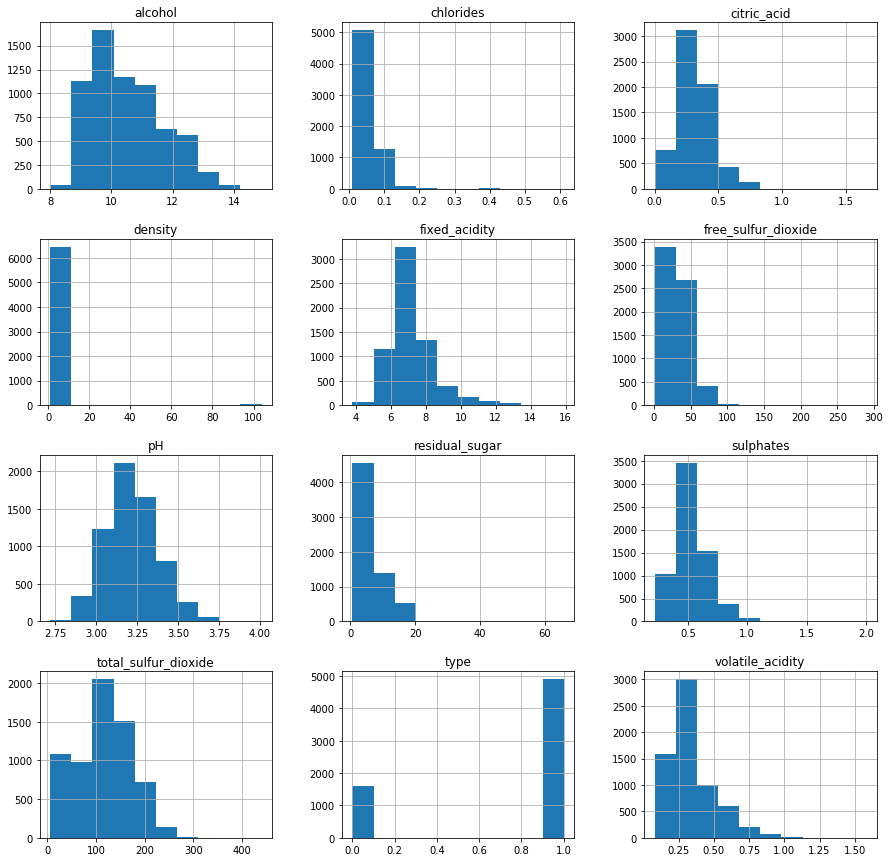

In [15]:
x.iloc[:,:].hist(figsize=(15,15))
plt.show()

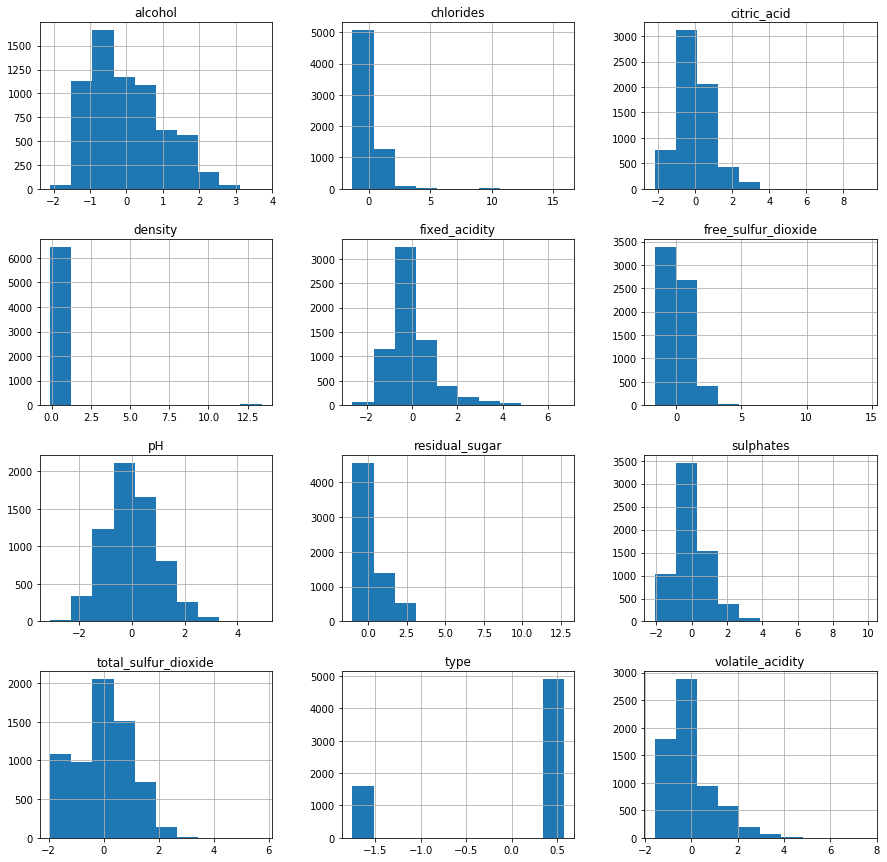

In [16]:
## NORMALIZANDO OS DADOS
x_norm = preprocessing.scale(x)
x_norm = pd.DataFrame(x_norm, columns=x.columns)

x_norm.iloc[:,:].hist(figsize=(15,15))
plt.show()

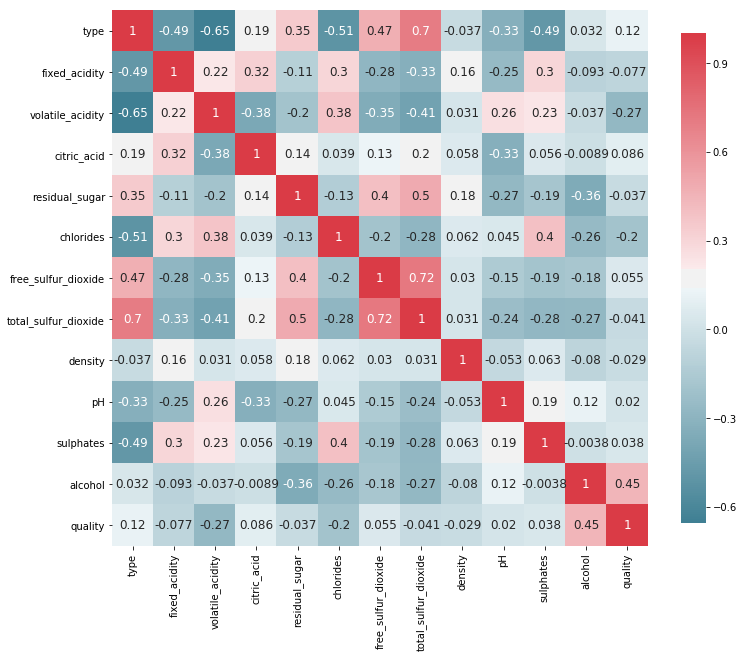

In [17]:
## VERIFICANDO A CORRELAÇÃO ENTRE OS ATRIBUTOS
import seaborn as sns
corr = dados.corr()
_ , ax = plt.subplots( figsize =( 12 , 10 ) )

cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = {'fontsize' : 12 })



In [18]:
# type - total_sulfur_dioxide
# free sulfur - total sulfur dioxide


# <font color = 'red'> 1 - MODELOS COM 3 CLASSES </font>

In [19]:
## MODELOS UTILIZADOS PARA 3 CLASSES

modelos = [ SVC(),#C= 10, gamma= 0.001, kernel= 'linear', probability= False),
            RandomForestClassifier(),#criterion='entropy', max_depth= None, max_features='sqrt',n_estimators= 10000),
            LogisticRegression(),#solver='lbfgs',multi_class='multinomial',class_weight='balanced',random_state=0),
            KNeighborsClassifier(),#n_neighbors=11),
            ]


In [20]:
#DEFININDO 3 DIVISOES DE QUALIDADE: 1–4 RUIM, 5–6 BOM, 7–10 ÓTIMO
bins = [1,4,6,10]

#DEFININDO CLASSES PARA QUALIDADE: 0-RUIM, 1-BOM, 2-ÓTIMO
quality_labels=[0,1,2]

y = pd.cut(dados['quality'], bins=bins, labels=quality_labels, include_lowest=True)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.20, random_state=4)

feat_import = True
run_ml(modelos, x_train,x_test,y_train,y_test)



==> SVC
  Accuracy  = 0.782308 


==> RandomForestClassifier
  Accuracy  = 0.826154 


==> LogisticRegression
  Accuracy  = 0.773077 


==> KNeighborsClassifier
  Accuracy  = 0.753846 


==> SVC
  Accuracy  = 0.782308 


==> RandomForestClassifier
  Cols:  ['volatile_acidity', 'residual_sugar', 'chlorides', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
  Accuracy  = 0.825385 


==> LogisticRegression
  Accuracy  = 0.773077 


==> KNeighborsClassifier
  Accuracy  = 0.753846 



In [22]:
### SEM A COLUNA TYPE
feat_import = True
run_ml(modelos, x_train.iloc[:,1:],x_test.iloc[:,1:],y_train,y_test)



==> SVC
  Accuracy  = 0.782308 


==> RandomForestClassifier
  Accuracy  = 0.828462 


==> LogisticRegression
  Accuracy  = 0.771538 


==> KNeighborsClassifier
  Accuracy  = 0.753846 


==> SVC
  Accuracy  = 0.782308 


==> RandomForestClassifier
  Cols:  ['residual_sugar', 'density', 'alcohol']
  Accuracy  = 0.800769 


==> LogisticRegression
  Accuracy  = 0.771538 


==> KNeighborsClassifier
  Accuracy  = 0.753846 



### <font color = 'red'>  1.1 - MODELOS COM DADOS BALANCEADOS </font>

In [23]:
warnings.filterwarnings('ignore')


In [24]:
data_o, target_o = SMOTE().fit_sample(x,y)

data_o   = pd.DataFrame(data_o, columns= x.columns)
target_o = pd.DataFrame(target_o, columns= dados_clean.iloc[:,-1:].columns)


In [25]:
x_train_balanc, x_test_balanc, y_train_balanc, y_test_balanc = train_test_split(data_o,
                                                                                target_o, 
                                                    test_size=0.20, random_state=4)

feat_import = True
run_ml(modelos, x_train_balanc,x_test_balanc,y_train_balanc,y_test_balanc)



==> SVC
  Accuracy  = 0.865997 


==> RandomForestClassifier
  Accuracy  = 0.903853 


==> LogisticRegression
  Accuracy  = 0.655276 


==> KNeighborsClassifier
  Accuracy  = 0.825126 


==> SVC
  Accuracy  = 0.865997 


==> RandomForestClassifier
  Cols:  ['volatile_acidity', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'sulphates', 'alcohol']
  Accuracy  = 0.890117 


==> LogisticRegression
  Accuracy  = 0.655276 


==> KNeighborsClassifier
  Accuracy  = 0.825126 



In [26]:
## MODELO SEM COLUNA TYPE
feat_import = True
run_ml(modelos, x_train_balanc.iloc[:,1:],x_test_balanc.iloc[:,1:],y_train_balanc,y_test_balanc)



==> SVC
  Accuracy  = 0.869012 


==> RandomForestClassifier
  Accuracy  = 0.903183 


==> LogisticRegression
  Accuracy  = 0.622111 


==> KNeighborsClassifier
  Accuracy  = 0.824791 


==> SVC
  Accuracy  = 0.869012 


==> RandomForestClassifier
  Cols:  ['volatile_acidity', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'alcohol']
  Accuracy  = 0.881742 


==> LogisticRegression
  Accuracy  = 0.622111 


==> KNeighborsClassifier
  Accuracy  = 0.824791 



### <font color = 'red'>  1.2 - MODELOS (3 CLASSES) COM DADOS NORMALIZADOS </font>


In [27]:
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(x_norm, y,
                                                                        test_size=0.20, random_state=4)

feat_import = True
run_ml(modelos, x_train_norm,x_test_norm,y_train_norm,y_test_norm)



==> SVC
  Accuracy  = 0.787692 


==> RandomForestClassifier
  Accuracy  = 0.823077 


==> LogisticRegression
  Accuracy  = 0.780000 


==> KNeighborsClassifier
  Accuracy  = 0.799231 


==> SVC
  Accuracy  = 0.787692 


==> RandomForestClassifier
  Cols:  ['volatile_acidity', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
  Accuracy  = 0.826923 


==> LogisticRegression
  Accuracy  = 0.780000 


==> KNeighborsClassifier
  Accuracy  = 0.799231 



### <font color = 'red'>  1.3 - MODELOS (3 CLASSES) COM DADOS NORMALIZADOS E BALANCEADOS </font>


In [28]:
data_o_norm, target_o_norm = SMOTE().fit_sample(x_norm,y)

data_o_norm   = pd.DataFrame(data_o_norm, columns= x.columns)
target_o_norm = pd.DataFrame(target_o_norm, columns= dados_clean.iloc[:,-1:].columns)

x_train_norm_balanc, x_test_norm_balanc, \
y_train_norm_balanc, y_test_norm_balanc = train_test_split(data_o_norm, target_o_norm, 
                                                    test_size=0.20, random_state=4)

feat_import = True
run_ml(modelos,x_train_norm_balanc,x_test_norm_balanc,y_train_norm_balanc,y_test_norm_balanc)



==> SVC
  Accuracy  = 0.789280 


==> RandomForestClassifier
  Accuracy  = 0.913568 


==> LogisticRegression
  Accuracy  = 0.648241 


==> KNeighborsClassifier
  Accuracy  = 0.870017 


==> SVC
  Accuracy  = 0.789280 


==> RandomForestClassifier
  Cols:  ['volatile_acidity', 'citric_acid', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'sulphates', 'alcohol']
  Accuracy  = 0.896482 


==> LogisticRegression
  Accuracy  = 0.648241 


==> KNeighborsClassifier
  Accuracy  = 0.870017 



# <font color = 'red'> 2 - MODELOS COM 2 CLASSES </font>

In [29]:
## MODELOS UTILIZADOS PARA CLASSIFICAÇÃO EM 2 CLASSES (BINARIA)

modelos_two = [ SVC(),#C= 10, gamma= 0.001, kernel= 'linear', probability= False),
                RandomForestClassifier(),#criterion='entropy', max_depth= None, max_features='sqrt',n_estimators= 10000),
                LogisticRegression(),#solver='lbfgs',multi_class='multinomial',class_weight='balanced',random_state=0),
                DecisionTreeClassifier(),#max_depth=20, min_samples_split=50), #81.3%
                ExtraTreesClassifier(),#n_estimators=10, max_depth=None,min_samples_split=2, random_state=0), #80.6%
                GradientBoostingClassifier(),#n_estimators=1000, learning_rate=1.0,max_depth=1, random_state=0),
                GaussianNB(),
                BernoulliNB(),
                KNeighborsClassifier(),#n_neighbors=11),
                BaggingClassifier(),
            ]

In [30]:
x_two = x.copy()
#x_two.head()

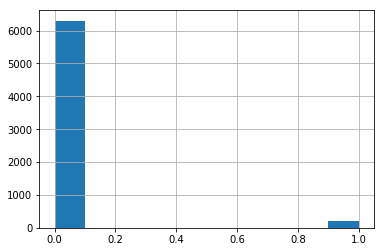

In [31]:
#DEFININDO 2 DIVISOES DE QUALIDADE: 1–7 RUIM, 7–10 ÓTIMO
bins = [1, 7, 10]

#DEFININDO CLASSES DE QUALIDADE: 0–RUIM, 1-ÓTIMO
quality_labels=[0,1]

y_two = pd.cut(dados['quality'], bins=bins, labels=quality_labels, include_lowest=True)
y_two.hist()

In [32]:
x_train_two, x_test_two, y_train_two, y_test_two = train_test_split(x_two,y_two, test_size=0.20, random_state=4)

In [33]:
#plotAuc = True
#plotCm = False

feat_import = True
run_ml(modelos_two, x_train_two,x_test_two,y_train_two,y_test_two)



==> SVC
  Accuracy  = 0.968462 


==> RandomForestClassifier
  Accuracy  = 0.971538 


==> LogisticRegression
  Accuracy  = 0.966154 


==> DecisionTreeClassifier
  Accuracy  = 0.956923 


==> ExtraTreesClassifier
  Accuracy  = 0.973846 


==> GradientBoostingClassifier
  Accuracy  = 0.966923 


==> GaussianNB
  Accuracy  = 0.600000 


==> BernoulliNB
  Accuracy  = 0.966154 


==> KNeighborsClassifier
  Accuracy  = 0.963077 


==> BaggingClassifier
  Accuracy  = 0.968462 


==> SVC
  Accuracy  = 0.968462 


==> RandomForestClassifier
  Cols:  ['fixed_acidity', 'residual_sugar', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
  Accuracy  = 0.969231 


==> LogisticRegression
  Accuracy  = 0.966154 


==> DecisionTreeClassifier
  Cols:  ['fixed_acidity', 'volatile_acidity', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'pH', 'sulphates', 'alcohol']
  Accuracy  = 0.948462 


==> ExtraTreesClassifier
  Cols:  ['fixed_acidity', 'volatile_acidity', 'c

### <font color = 'red'>  2.1 - MODELOS PARA 2 CLASSES COM DADOS BALANCEADOS </font>

In [34]:
from imblearn.over_sampling import SMOTE, ADASYN
data_o_two, target_o_two = SMOTE().fit_sample(x_two,y_two)

data_o_two   = pd.DataFrame(data_o_two, columns= x_two.columns)
target_o_two = pd.DataFrame(target_o_two, columns= ['class']  )


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1744ffa518>]],
      dtype=object)

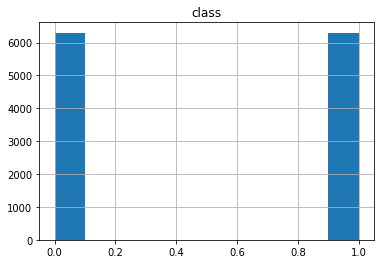

In [35]:
target_o_two.hist()

In [36]:
x_train_two_bal, x_test_two_bal, y_train_two_bal, y_test_two_bal = \
                                                    train_test_split(data_o_two,target_o_two, 
                                                                     test_size=0.20, random_state=4)



In [37]:
#plotAuc = True
#plotCm = True
feat_import = True
run_ml(modelos_two, x_train_two_bal,x_test_two_bal,y_train_two_bal,y_test_two_bal)


==> SVC
  Accuracy  = 0.954762 


==> RandomForestClassifier
  Accuracy  = 0.977381 


==> LogisticRegression
  Accuracy  = 0.742857 


==> DecisionTreeClassifier
  Accuracy  = 0.953571 


==> ExtraTreesClassifier
  Accuracy  = 0.981349 


==> GradientBoostingClassifier
  Accuracy  = 0.904762 


==> GaussianNB
  Accuracy  = 0.615476 


==> BernoulliNB
  Accuracy  = 0.586905 


==> KNeighborsClassifier
  Accuracy  = 0.902381 


==> BaggingClassifier
  Accuracy  = 0.973016 


==> SVC
  Accuracy  = 0.954762 


==> RandomForestClassifier
  Cols:  ['residual_sugar', 'density', 'alcohol']
  Accuracy  = 0.934127 


==> LogisticRegression
  Accuracy  = 0.742857 


==> DecisionTreeClassifier
  Cols:  ['volatile_acidity', 'alcohol']
  Accuracy  = 0.957540 


==> ExtraTreesClassifier
  Cols:  ['total_sulfur_dioxide', 'alcohol']
  Accuracy  = 0.941270 


==> GradientBoostingClassifier
  Cols:  ['volatile_acidity', 'alcohol']
  Accuracy  = 0.875794 


==> GaussianNB
  Accuracy  = 0.615476 


==> B

### <font color = 'red'>  2.2 - MODELOS PARA 2 CLASSES COM DADOS NORM E BALANCEADOS </font>


In [38]:
data_o_two_norm, target_o_two_norm = SMOTE().fit_sample(x_norm,y_two)

data_o_two_norm   = pd.DataFrame(data_o_two_norm, columns= x.columns)
target_o_two_norm = pd.DataFrame(target_o_two_norm, columns= ["quality"])

x_train_two_norm_balanc, x_test_two_norm_balanc, \
y_train_two_norm_balanc, y_test_two_norm_balanc = train_test_split(data_o_two_norm, target_o_two_norm, 
                                                    test_size=0.20, random_state=4)


In [39]:
feat_import = True
run_ml(modelos_two, x_train_two_norm_balanc,x_test_two_norm_balanc,
       y_train_two_norm_balanc,y_test_two_norm_balanc)



==> SVC
  Accuracy  = 0.888095 


==> RandomForestClassifier
  Accuracy  = 0.981349 


==> LogisticRegression
  Accuracy  = 0.736905 


==> DecisionTreeClassifier
  Accuracy  = 0.958730 


==> ExtraTreesClassifier
  Accuracy  = 0.990079 


==> GradientBoostingClassifier
  Accuracy  = 0.909524 


==> GaussianNB
  Accuracy  = 0.615476 


==> BernoulliNB
  Accuracy  = 0.728968 


==> KNeighborsClassifier
  Accuracy  = 0.942063 


==> BaggingClassifier
  Accuracy  = 0.970635 


==> SVC
  Accuracy  = 0.888095 


==> RandomForestClassifier
  Cols:  ['volatile_acidity', 'chlorides', 'density', 'alcohol']
  Accuracy  = 0.960714 


==> LogisticRegression
  Accuracy  = 0.736905 


==> DecisionTreeClassifier
  Cols:  ['volatile_acidity', 'alcohol']
  Accuracy  = 0.961508 


==> ExtraTreesClassifier
  Cols:  ['total_sulfur_dioxide', 'alcohol']
  Accuracy  = 0.926587 


==> GradientBoostingClassifier
  Cols:  ['volatile_acidity', 'citric_acid', 'alcohol']
  Accuracy  = 0.877778 


==> GaussianNB
 

In [40]:
## EXECUÇÃO SEM A COLUNA TYPE
run_ml(modelos_two, x_train_two_norm_balanc.iloc[:,1:],x_test_two_norm_balanc.iloc[:,1:],
       y_train_two_norm_balanc,y_test_two_norm_balanc)



==> SVC
  Accuracy  = 0.893254 


==> RandomForestClassifier
  Accuracy  = 0.979762 


==> LogisticRegression
  Accuracy  = 0.734127 


==> DecisionTreeClassifier
  Accuracy  = 0.955952 


==> ExtraTreesClassifier
  Accuracy  = 0.988095 


==> GradientBoostingClassifier
  Accuracy  = 0.909524 


==> GaussianNB
  Accuracy  = 0.623016 


==> BernoulliNB
  Accuracy  = 0.721429 


==> KNeighborsClassifier
  Accuracy  = 0.942460 


==> BaggingClassifier
  Accuracy  = 0.973016 


==> SVC
  Accuracy  = 0.893254 


==> RandomForestClassifier
  Cols:  ['volatile_acidity', 'alcohol']
  Accuracy  = 0.957143 


==> LogisticRegression
  Accuracy  = 0.734127 


==> DecisionTreeClassifier
  Cols:  ['volatile_acidity', 'alcohol']
  Accuracy  = 0.962302 


==> ExtraTreesClassifier
  Cols:  ['alcohol']
  Accuracy  = 0.898016 


==> GradientBoostingClassifier
  Cols:  ['volatile_acidity', 'alcohol']
  Accuracy  = 0.877778 


==> GaussianNB
  Accuracy  = 0.623016 


==> BernoulliNB
  Accuracy  = 0.721429

# <font color = 'red'>  MODELO FINAL ExtraTreesClassifier </font>



ACC:  0.9753846153846154

CV:  0.9799877282488811

Confusion Matrix Stats
0/0: 100.00% (1256/1256)
0/1: 0.00% (0/1256)
1/0: 72.73% (32/44)
1/1: 27.27% (12/44)


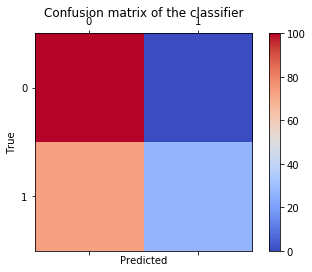

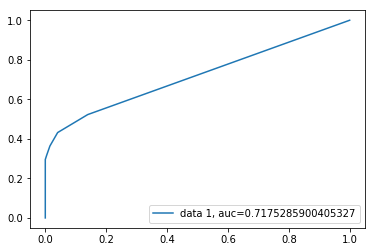

PRECISION:  1.0
RECALL:  0.2727272727272727
FSCORE:  0.42857142857142855


In [41]:
## MODELOS COM OS DADOS NORMAIS
x_treino = x_train_two
x_teste  = x_test_two
y_treino = y_train_two
y_teste  = y_test_two

et_1 = ExtraTreesClassifier()
et_1.fit(x_treino,y_treino)

preds = et_1.predict(x_teste)
print("\nACC: ",accuracy_score(y_pred=preds,y_true=y_teste) )

etc_eval = cross_val_score(estimator = et_1, X = x_treino, y = y_treino, cv = 10)
print("\nCV: ",etc_eval.mean())
print()

labels = list(np.unique(y_treino)) #[0,1]
cm     = confusion_matrix(y_teste, preds,labels=labels)
plot_cm(cm, labels)

plot_auc_curve(et_1, x_teste, y_teste)


print("PRECISION: ", metrics.precision_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("RECALL: ", metrics.recall_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("FSCORE: ", metrics.f1_score(y_pred=preds, y_true=y_teste))#, average='binary'))



ACC:  0.9785714285714285

CV:  0.9805517134030044

Confusion Matrix Stats
0/0: 96.90% (1251/1291)
0/1: 3.10% (40/1291)
1/0: 1.14% (14/1229)
1/1: 98.86% (1215/1229)


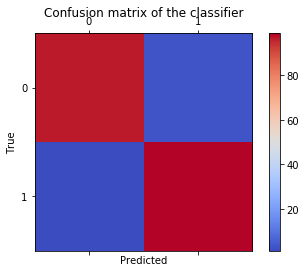

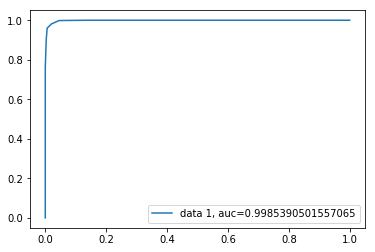

PRECISION:  0.9681274900398407
RECALL:  0.9886086248982913
FSCORE:  0.9782608695652174


In [42]:
## MODELOS COM OS DADOS BALANCEADOS
x_treino = x_train_two_bal
x_teste  = x_test_two_bal
y_treino = y_train_two_bal
y_teste  = y_test_two_bal

et_2 = ExtraTreesClassifier()
et_2.fit(x_treino,y_treino)

preds = et_2.predict(x_teste)
print("\nACC: ",accuracy_score(y_pred=preds,y_true=y_teste) )

etc_eval = cross_val_score(estimator = et_2, X = x_treino, y = y_treino, cv = 10)
print("\nCV: ",etc_eval.mean())
print()

labels = list(np.unique(y_treino)) #[0,1]
cm     = confusion_matrix(y_teste, preds,labels=labels)
plot_cm(cm, labels)

plot_auc_curve(et_2, x_teste, y_teste)

print("PRECISION: ", metrics.precision_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("RECALL: ", metrics.recall_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("FSCORE: ", metrics.f1_score(y_pred=preds, y_true=y_teste))#, average='binary'))



ACC:  0.9888888888888889

CV:  0.9870017588950031

Confusion Matrix Stats
0/0: 98.37% (1270/1291)
0/1: 1.63% (21/1291)
1/0: 0.57% (7/1229)
1/1: 99.43% (1222/1229)


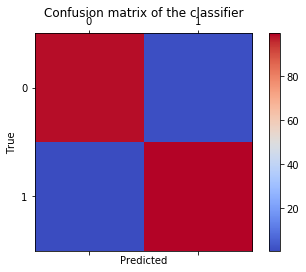

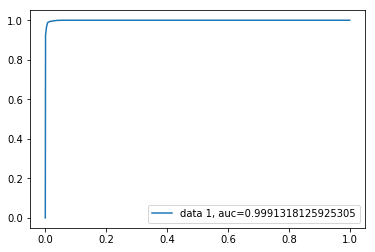

PRECISION:  0.9831053901850362
RECALL:  0.9943043124491456
FSCORE:  0.988673139158576


In [43]:
## MODELOS COM OS DADOS NORMALIZADOS E BALANCEADOS
x_treino = x_train_two_norm_balanc
x_teste  = x_test_two_norm_balanc
y_treino = y_train_two_norm_balanc
y_teste  = y_test_two_norm_balanc

et_3 = ExtraTreesClassifier()
et_3.fit(x_treino,y_treino)

preds = et_3.predict(x_teste)
print("\nACC: ",accuracy_score(y_pred=preds,y_true=y_teste) )

etc_eval = cross_val_score(estimator = et_3, X = x_treino, y = y_treino, cv = 20)
print("\nCV: ",etc_eval.mean())
print()

labels = list(np.unique(y_treino)) #[0,1]
cm     = confusion_matrix(y_teste, preds,labels=labels)
plot_cm(cm, labels)

plot_auc_curve(et_3, x_teste, y_teste)

print("PRECISION: ", metrics.precision_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("RECALL: ", metrics.recall_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("FSCORE: ", metrics.f1_score(y_pred=preds, y_true=y_teste))#, average='binary'))



# <font color = 'red'>  SALVANDO MODELO </font>


In [ ]:
## SALVANDO MODELO COM O PACOTE JOBLIB

In [46]:
dic_save_model = dict({
    'model': et_3,
    'metadata': {
        'name': 'ExtraTreesClassifier model to classfier quality of wine',
        'author': 'Gabriel Lima Gomes',
        'date': '2019-05-22',
        'source_code_version': '0.1',
        'metrics': {
            'accuracy': 98.88
        }
    }
})

In [48]:
joblib.dump(dic_save_model, 'model_etc.joblib')

['model_etc.joblib']

# <font color = 'red'>  MODELO FINAL RamdonFores </font>


In [ ]:
x_treino = x_train_two
x_teste  = x_test_two
y_treino = y_train_two
y_teste  = y_test_two

rf = RandomForestClassifier()
rf.fit(x_treino,y_treino)

preds = rf.predict(x_teste)
print("\nACC: ",accuracy_score(y_pred=preds,y_true=y_teste) )

rfc_eval = cross_val_score(estimator = rf, X = x_treino, y = y_treino, cv = 10)
print("\nCV: ",rfc_eval.mean())
print()

labels = list(np.unique(y_treino)) #[0,1]
cm     = confusion_matrix(y_teste, preds,labels=labels)
plot_cm(cm, labels)

plot_auc_curve(rf, x_teste, y_teste)


print("PRECISION: ", metrics.precision_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("RECALL: ", metrics.recall_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("FSCORE: ", metrics.f1_score(y_pred=preds, y_true=y_teste))#, average='binary'))


In [ ]:
x_treino = x_train_two_bal
x_teste  = x_test_two_bal
y_treino = y_train_two_bal
y_teste  = y_test_two_bal

rf = RandomForestClassifier()
rf.fit(x_treino,y_treino)

preds = rf.predict(x_teste)
print("\nACC: ",accuracy_score(y_pred=preds,y_true=y_teste) )

rfc_eval = cross_val_score(estimator = rf, X = x_treino, y = y_treino, cv = 10)
print("\nCV: ",rfc_eval.mean())
print()

labels = list(np.unique(y_treino)) #[0,1]
cm     = confusion_matrix(y_teste, preds,labels=labels)
plot_cm(cm, labels)

plot_auc_curve(rf, x_teste, y_teste)

print("PRECISION: ", metrics.precision_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("RECALL: ", metrics.recall_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("FSCORE: ", metrics.f1_score(y_pred=preds, y_true=y_teste))#, average='binary'))


In [ ]:
x_treino = x_train_two_norm_balanc
x_teste  = x_test_two_norm_balanc
y_treino = y_train_two_norm_balanc
y_teste  = y_test_two_norm_balanc

rf = RandomForestClassifier()
rf.fit(x_treino,y_treino)

preds = rf.predict(x_teste)
print("\nACC: ",accuracy_score(y_pred=preds,y_true=y_teste) )

rfc_eval = cross_val_score(estimator = rf, X = x_treino, y = y_treino, cv = 20)
print("\nCV: ",rfc_eval.mean())
print()

labels = list(np.unique(y_treino)) #[0,1]
cm     = confusion_matrix(y_teste, preds,labels=labels)
plot_cm(cm, labels)

plot_auc_curve(rf, x_teste, y_teste)

print("PRECISION: ", metrics.precision_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("RECALL: ", metrics.recall_score(y_pred=preds, y_true=y_teste))#, average='binary'))
print("FSCORE: ", metrics.f1_score(y_pred=preds, y_true=y_teste))#, average='binary'))
